In [ ]:
import chipwhisperer as cw
import matplotlib.pyplot as plt
import numpy as np

import simon_64_128

from helper import *
from measurement import Measurement, Measurements

/home/nico/miniconda3/envs/simon/lib/python3.13/site-packages/chipwhisperer/capture/trace/TraceWhisperer.py:31: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources # type: ignore


# Import Trace

In [26]:
project = cw.import_project("./traces/02_simon_plain_10000/trace.zip", overwrite=True)

In [28]:
NUM_MEASUREMENTS = len(project.traces)
print(NUM_MEASUREMENTS)

VALS_PER_MEASUREMENT = len(project.traces[0].wave)
print(VALS_PER_MEASUREMENT)

CORR_DIFF_THRESHOLD = 0.05

10000
5000


# Transform Trace Project into Measurement object

In [ ]:
measurements = Measurements()



for trace in project.traces:
    plaintext = np.frombuffer(trace.textin, dtype=np.uint32)
    ciphertext = np.frombuffer(trace.textout, dtype=np.uint32)
    power = np.array(trace.wave, dtype=np.uint32)
    measurements.append(Measurement(plaintext, ciphertext, power))

measurements.update_power_2d()


In [ ]:
print(measurements.power_2d)
print(measurements[0].power)

[599. 423. 446. ... 415. 460. 482.]
[[599 423 446 ... 415 460 482]
 [599 426 449 ... 414 457 477]
 [600 424 447 ... 417 461 480]
 ...
 [596 431 449 ... 422 462 479]
 [594 429 445 ... 423 463 482]
 [595 431 449 ... 422 466 482]]
[599. 423. 446. ... 415. 460. 482.]


# Attack

In [23]:
# start with empty key as hypothesis
empty_key = np.zeros((4,), dtype=np.uint32)
start_hypo = KeyHypothesis(empty_key, 0)

promising_hypos = [start_hypo]

for attack_step in range(16):
    print(f"Perform Attack Step {attack_step+1}/16")

    sub_hypos: list[KeyHypothesis] = []

    for h in promising_hypos:
        sub_hypos.extend(h.get_sub_hypos())

    print(f"Find correlations for {len(sub_hypos)} hypotheses.")

    for hypo in sub_hypos:
        calc_corr_for_hypo(hypo, measurements)

    promising_hypos = filter_hypos(sub_hypos, CORR_DIFF_THRESHOLD)

    print(f"Found {len(promising_hypos)} promising hypotheses.")
    for hypo in promising_hypos:
        
        print(f"{array_to_hex_str(hypo.key)}: correlation: {hypo.corr}")

if len(promising_hypos) > 0:
    # Do final check against ciphertext
    for hypo in promising_hypos:
        ciphertext, _ = simon_64_128.encrypt_block(measurements[0].plaintext, hypo.key)
        if np.array_equal(measurements[0].ciphertext, ciphertext):
            extracted_key = hypo.key
            print(f"Extracted Key: {array_to_hex_str(extracted_key)}")
            break
else:
    print("Could not determine key")

Perform Attack Step 1/16
Find correlations for 256 hypotheses.
Found 8 promising hypotheses.
0x00000000 0x00000000 0x00000000 0x00000070: correlation: -0.20824467726118412
0x00000000 0x00000000 0x00000000 0x00000071: correlation: -0.22575897385988994
0x00000000 0x00000000 0x00000000 0x00000072: correlation: -0.19804903844975547
0x00000000 0x00000000 0x00000000 0x00000073: correlation: -0.21751283098117632
0x00000000 0x00000000 0x00000000 0x0000008C: correlation: 0.21751283098117638
0x00000000 0x00000000 0x00000000 0x0000008D: correlation: 0.19804903844975547
0x00000000 0x00000000 0x00000000 0x0000008E: correlation: 0.22575897385988994
0x00000000 0x00000000 0x00000000 0x0000008F: correlation: 0.20824467726118412
Perform Attack Step 2/16
Find correlations for 2048 hypotheses.


KeyboardInterrupt: 

# Attack Insights

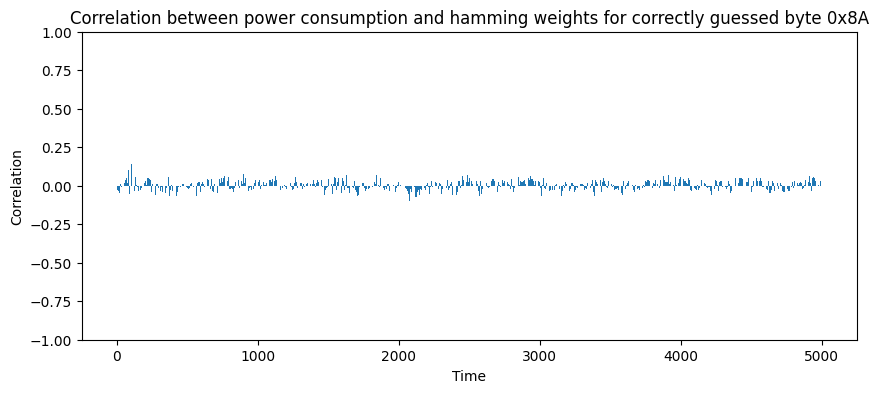

In [24]:
key = np.array([0x19013660, 0x86de7696, 0xd0427aff, 0x738dd98a], dtype=np.uint32)

# Print correlation in comparison to time

guessed_key = np.zeros((4,), dtype=np.uint32)
guessed_byte = key[3] & 0xFF
guessed_key[3] |= guessed_byte

expected_hws = np.array(
        [get_hw_for_guessed_key_byte(m.plaintext, guessed_key, 0, np.uint32(0xFF)) for m in measurements.entries], 
        dtype=np.uint32)

correlations = np.array(
        [
            np.corrcoef(expected_hws, measurements.power_2d[:, t])[0, 1]
            for t in range(measurements.power_2d.shape[1])
        ],
        dtype=np.float64,
    )

plt.figure(figsize=(10,4))
x = np.arange(len(correlations))
plt.bar(x, correlations)
plt.xlabel("Time")
plt.ylabel("Correlation")
plt.title(f"Correlation between power consumption and hamming weights for correctly guessed byte 0x{guessed_byte:02X}")
plt.ylim(-1, 1)
plt.show()